# Swap Set Analysis
## Purpose
Swap set analysis is a method used to compare two competing models (in this case, random forest models predicting loan default probabilities) based on their predictions. Its primary purpose is to identify and analyze how the predictions of one model differ from another in terms of specific subsets of the dataset.

## Key Concepts
* **Swap-in:** Instances where Model 2 predicts a different outcome (e.g., approved) compared to Model 1 (e.g., declined).
* **Swap-out**: Instances where Model 1 predicts a different outcome compared to Model 2.
* **No Change**: Instances where both models predict the same outcome.

## Steps Involved

1. **Prediction and Probability Calculation:** Obtain predictions and corresponding probabilities from both models for a test dataset.

2. **Threshold Definition:** Define thresholds for each model to categorize predictions into approved (probability < 0.1) and declined (probability >= 0.1) categories.

3. **Data Preparation:** Create a DataFrame to organize predictions and probabilities for easier manipulation.

4. **Classification:** Classify each sample into swap-in, swap-out, or no-change categories based on the defined thresholds.

5. **Analysis:** Analyze the swap-in, swap-out, and no-change populations to understand how the models differ and where they agree.

# Interpretation and Decision Making
## Interpretation
* **Identifying Differences:** The contingency table/heatmap visually highlights where the two models differ in their predictions (swap-in and swap-out).

* **Magnitude:** The counts in each cell quantify the magnitude of differences between the models.

## Decision Making
* **Model Comparison:** Evaluate which model performs better overall and in specific scenarios (e.g., handling of approved vs declined cases).

* **Insights:** Gain insights into why and how models differ, which can inform improvements or adjustments in model development or deployment.

* **Business Implications:** Use insights to make informed decisions, such as adjusting thresholds, combining models, or focusing on specific areas where model performance is crucial.

In [ ]:
# Necessary Imports

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [25]:
def load_data(file_path):
    """
    Load data from a CSV file.
    
    Parameters:
    - file_path (str): Path to the CSV file.
    
    Returns:
    - DataFrame: Loaded data.
    """
    return pd.read_csv(file_path)

def preprocess_data(df, features_model1, features_model2, target):
    """
    Preprocess data for Random Forests.
    
    Parameters:
    - df (DataFrame): Raw data.
    - features_model1 (list): Features for the first model.
    - features_model2 (list): Features for the second model.
    - target (str): The target variable.
    
    Returns:
    - DataFrame: Preprocessed data.
    """
    required_columns = list(set(features_model1 + features_model2 + [target]))
    df = df[required_columns].copy()  # Make a copy to avoid SettingWithCopyWarning
    
    # Convert 'term' to numeric
    if 'term' in df.columns:
        df['term'] = df['term'].apply(lambda x: int(x.strip().split()[0]))
    
    # Encode loan_status into numerical labels
    label_encoder = LabelEncoder()
    df['loan_status_encoded'] = label_encoder.fit_transform(df['loan_status'])
    
    # Check the encoded classes
    encoded_classes = label_encoder.classes_

    # Find the index of 'Default' in the classes
    default_index = list(encoded_classes).index('Default')

    # Check the corresponding encoded value
    default_encoded_value = label_encoder.transform(['Default'])[0]
    
    print(f"The encoded value for 'Default' is: {default_encoded_value}")
    
    # Convert 'grade' to one-hot encoding
    encoder = OneHotEncoder(sparse=False)
    encoded = encoder.fit_transform(df[['grade']])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['grade']))

    # Concatenate encoded_df with your original dataframe
    df = pd.concat([df.drop(['grade'], axis=1), encoded_df], axis=1)
    
    # Fill missing values (if any)
    df = df.fillna(0)
    
    return df

def train_random_forest_model(X_train, y_train):
    """
    Train a Random Forest model.
    
    Parameters:
    - X_train (DataFrame): The training features.
    - y_train (Series): The training target.
    
    Returns:
    - RandomForestClassifier: Fitted Random Forest model.
    """
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the Random Forest model on test data.
    
    Parameters:
    - model (RandomForestClassifier): The fitted model.
    - X_test (DataFrame): The testing features.
    - y_test (Series): The testing target.
    
    Returns:
    - dict: Dictionary containing evaluation metrics.
    """
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    
    return {
        'Accuracy': accuracy,
        'Classification Report': report
    }

def compare_random_forest_models(model1, model2, X_test1, y_test1, X_test2, y_test2):
    """
    Compare two Random Forest models.
    
    Parameters:
    - model1 (RandomForestClassifier): The first model.
    - model2 (RandomForestClassifier): The second model.
    - X_test1 (DataFrame): The testing features for model 1.
    - y_test1 (Series): The testing target for model 1.
    - X_test2 (DataFrame): The testing features for model 2.
    - y_test2 (Series): The testing target for model 2.
    
    Returns:
    - None
    """
    eval1 = evaluate_model(model1, X_test1, y_test1)
    eval2 = evaluate_model(model2, X_test2, y_test2)
    
    print("Model 1 Evaluation Metrics:")
    print(eval1)
    
    print("\nModel 2 Evaluation Metrics:")
    print(eval2)

In [26]:
# Load and preprocess data
df = load_data('loan_data_2015.csv')
features_model1 = ['term', 'installment', 'delinq_2yrs', 'int_rate']
features_model2 = ['term', 'installment', 'delinq_2yrs', 'int_rate', 'annual_inc', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'grade']
target = 'loan_status'

df

C:\Users\victo\AppData\Local\Temp\ipykernel_30804\4200925560.py:11: DtypeWarning: Columns (19,47,55) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,60516983,64537751,20000,20000,20000,36 months,12.29,667.06,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,41000,NaN,NaN,NaN
1,60187139,64163931,11000,11000,11000,36 months,12.69,369.00,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,13100,NaN,NaN,NaN
2,60356453,64333218,7000,7000,7000,36 months,9.99,225.84,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,16300,NaN,NaN,NaN
3,59955769,63900496,10000,10000,10000,36 months,10.99,327.34,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,34750,NaN,NaN,NaN
4,58703693,62544456,9550,9550,9550,36 months,19.99,354.87,E,E4,...,NaN,NaN,NaN,NaN,NaN,NaN,14100,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421089,37257620,40030388,25000,25000,25000,36 months,20.99,941.75,E,E4,...,NaN,NaN,NaN,NaN,NaN,NaN,35500,NaN,NaN,NaN
421090,35998858,38700420,5875,5875,5875,36 months,15.59,205.37,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,12300,NaN,NaN,NaN
421091,37317288,40080027,10000,10000,10000,60 months,23.99,287.63,F,F2,...,NaN,NaN,NaN,NaN,NaN,NaN,7200,NaN,NaN,NaN
421092,36200493,38911833,19600,19600,19600,60 months,14.31,459.22,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,233000,NaN,NaN,NaN


In [27]:
new_df = preprocess_data(df, features_model1, features_model2, target)
new_df

The encoded value for 'Default' is: 2


C:\Users\victo\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,inq_last_6mths,loan_status,open_acc,revol_util,delinq_2yrs,annual_inc,int_rate,term,revol_bal,installment,loan_status_encoded,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,1,Charged Off,25,77.0,0,65000.0,12.29,36,31578,667.06,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,Charged Off,13,38.8,0,40000.0,12.69,36,5084,369.00,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,Charged Off,18,74.0,0,32000.0,9.99,36,12070,225.84,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2,Charged Off,18,66.0,0,48000.0,10.99,36,22950,327.34,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3,Charged Off,9,29.6,0,32376.0,19.99,36,4172,354.87,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421089,1,Late (31-120 days),13,63.2,0,55000.0,20.99,36,22438,941.75,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0
421090,0,Late (31-120 days),10,61.7,0,41000.0,15.59,36,7594,205.37,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0
421091,3,Late (31-120 days),6,60.2,0,35000.0,23.99,60,4317,287.63,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0
421092,2,Late (31-120 days),22,26.7,1,49000.0,14.31,60,141120,459.22,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
# Split data into train and test sets
features_model2 = ['term', 'installment', 'delinq_2yrs', 'int_rate', 'annual_inc', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F','grade_G' ]

X = new_df.drop(['loan_status', 'loan_status_encoded'], axis=1)
y = new_df['loan_status_encoded']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X[features_model1], y, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X[features_model2], y, test_size=0.3, random_state=42)

In [29]:
# Train Random Forest models
model1 = train_random_forest_model(X_train1, y_train1)
model2 = train_random_forest_model(X_train2, y_train2)

In [30]:
model1

RandomForestClassifier(random_state=42)

In [31]:
probabilities1 = model1.predict_proba(X_test1)
probabilities2 = model2.predict_proba(X_test2)

In [32]:
from sklearn.metrics import accuracy_score


predictions1 = model1.predict(X_test1)
accuracy1 = accuracy_score(y_test1, predictions1)

predictions2 = model2.predict(X_test2)
accuracy2 = accuracy_score(y_test2, predictions2)

print(f"Accuracy Model1: {accuracy1}")
print(f"Accuracy Model2: {accuracy2}")

Accuracy Model1: 0.8890595191919511
Accuracy Model2: 0.8981864813304942


In [33]:
from sklearn.metrics import classification_report

In [34]:
# Compare models
compare_random_forest_models(model1, model2, X_test1, y_test1, X_test2, y_test2)

Model 1 Evaluation Metrics:
{'Accuracy': 0.8890595191919511, 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.04      0.01      0.02       834\n           1       0.90      0.98      0.94    113186\n           2       0.00      0.00      0.00       139\n           3       0.10      0.02      0.03      6965\n           4       0.01      0.00      0.00       950\n           5       0.73      0.39      0.51      2555\n           6       0.00      0.00      0.00       343\n           7       0.03      0.01      0.01      1357\n\n    accuracy                           0.89    126329\n   macro avg       0.23      0.18      0.19    126329\nweighted avg       0.83      0.89      0.86    126329\n'}

Model 2 Evaluation Metrics:
{'Accuracy': 0.8981864813304942, 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       834\n           1       0.90      1.00      0.95   

C:\Users\victo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\victo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\victo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

def compare_models_ztest(y_test1, y_pred1, y_test2, y_pred2):
    # Calculate accuracies for each model
    accuracy1 = np.mean(y_test1 == y_pred1)
    accuracy2 = np.mean(y_test2 == y_pred2)
    
    # Number of samples in each test set
    n1 = len(y_test1)
    n2 = len(y_test2)
    
    # Number of correct predictions for each model
    correct1 = np.sum(y_test1 == y_pred1)
    correct2 = np.sum(y_test2 == y_pred2)
    
    # Proportions (accuracies)
    prop1 = correct1 / n1
    prop2 = correct2 / n2
    
    # Calculate pooled proportion
    pooled_prop = (correct1 + correct2) / (n1 + n2)
    
    # Calculate standard error of the difference
    SE_diff = np.sqrt(pooled_prop * (1 - pooled_prop) * (1 / n1 + 1 / n2))
    
    # Calculate Z-score
    z_score = (prop1 - prop2) / SE_diff
    
    # Calculate p-value
    p_value = 2 * (1 - norm.cdf(np.abs(z_score)))  # two-sided test
    
    # Print results
    print(f"Accuracy for Model 1: {accuracy1:.4f}")
    print(f"Accuracy for Model 2: {accuracy2:.4f}")
    print(f"Z-score: {z_score:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Determine significance
    alpha = 0.05
    if p_value < alpha:
        print("The difference in accuracies is statistically significant.")
    else:
        print("The difference in accuracies is not statistically significant.")

In [36]:
compare_models_ztest(y_test1, predictions1, y_test2, predictions2)

Accuracy for Model 1: 0.8891
Accuracy for Model 2: 0.8982
Z-score: -7.4398
P-value: 0.0000
The difference in accuracies is statistically significant.


In [39]:
def swap_set_analysis(X_test, y_test, probabilities_model1, probabilities_model2, threshold_model1=0.1, threshold_model2=0.1):
    # Assuming probabilities_model1 and probabilities_model2 are 2D arrays with shape (n_samples, n_classes)
    
    # Find index corresponding to label 2 (assuming 'Default' label is encoded as 2)
    label_index_default = 2
    
    # Extract probabilities for label 2 (Default)
    prob_model1_default = probabilities_model1[:, label_index_default]
    prob_model2_default = probabilities_model2[:, label_index_default]
    
    # Create DataFrame for easier manipulation
    swap_df = pd.DataFrame({
        'Probability_model1': prob_model1_default,
        'Probability_model2': prob_model2_default,
        'y_true': y_test  # assuming y_test contains actual loan statuses
    })
    
    # Determine swap-in, swap-out, and no-change populations
    swap_df['Prediction_model1'] = (prob_model1_default >= threshold_model1).astype(int)
    swap_df['Prediction_model2'] = (prob_model2_default >= threshold_model2).astype(int)
    
    swap_df['Swap_in'] = (swap_df['Prediction_model2'] == 1) & (swap_df['Prediction_model1'] == 0)
    swap_df['Swap_out'] = (swap_df['Prediction_model2'] == 0) & (swap_df['Prediction_model1'] == 1)
    swap_df['No_change'] = (swap_df['Prediction_model2'] == swap_df['Prediction_model1'])
    
    # Filter swap sets
    swap_in = swap_df[swap_df['Swap_in']]
    swap_out = swap_df[swap_df['Swap_out']]
    no_change = swap_df[swap_df['No_change']]
    
    return swap_in, swap_out, no_change

In [40]:
# Example usage:
# Assuming X_test, y_test, probabilities_model1, and probabilities_model2 are already defined
swap_in, swap_out, no_change = swap_set_analysis(X_test2, y_test2, probabilities1, probabilities2)

In [43]:
contingency_table = pd.DataFrame(index=['Model 1 Declined', 'Model 1 Approved'],
                                 columns=['Model 2 Declined', 'Model 2 Approved'],
                                 data=[[len(swap_out[swap_out['Probability_model1'] >= 0.1]),
                                        len(swap_in[swap_in['Probability_model2'] >= 0.1])],
                                       [len(swap_in[swap_in['Probability_model1'] < 0.1]),
                                        len(swap_out[swap_out['Probability_model2'] < 0.1])]])

In [49]:
contingency_table

,Model 2 Declined,Model 2 Approved
Model 1 Declined,157,31
Model 1 Approved,31,157


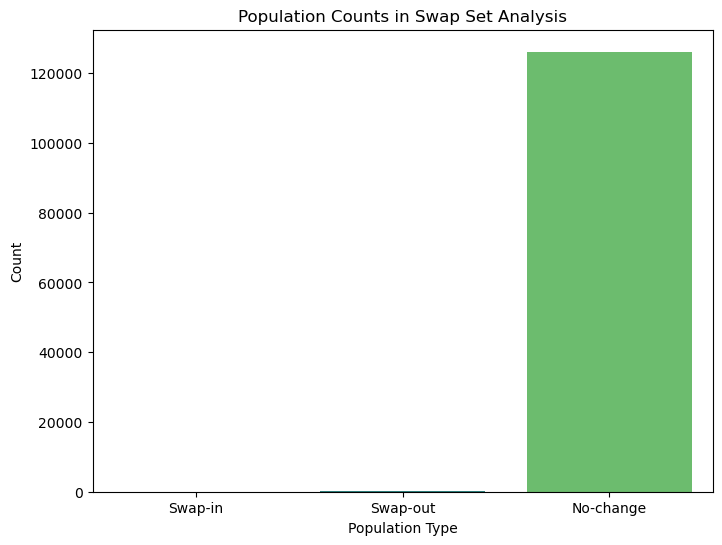

In [46]:
def plot_swap_population_counts(swap_in, swap_out, no_change):
    """
    Plots a bar chart showing counts of swap-in, swap-out, and no-change populations.

    Parameters:
    - swap_in: Indices of samples where Model 1 predicts declined and Model 2 predicts approved.
    - swap_out: Indices of samples where Model 1 predicts approved and Model 2 predicts declined.
    - no_change: Indices of samples where both models predict the same outcome.
    """
    labels = ['Swap-in', 'Swap-out', 'No-change']
    counts = [len(swap_in), len(swap_out), len(no_change)]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=counts, palette='viridis')
    plt.title('Population Counts in Swap Set Analysis')
    plt.xlabel('Population Type')
    plt.ylabel('Count')
    plt.show()

plot_swap_population_counts(swap_in, swap_out, no_change)

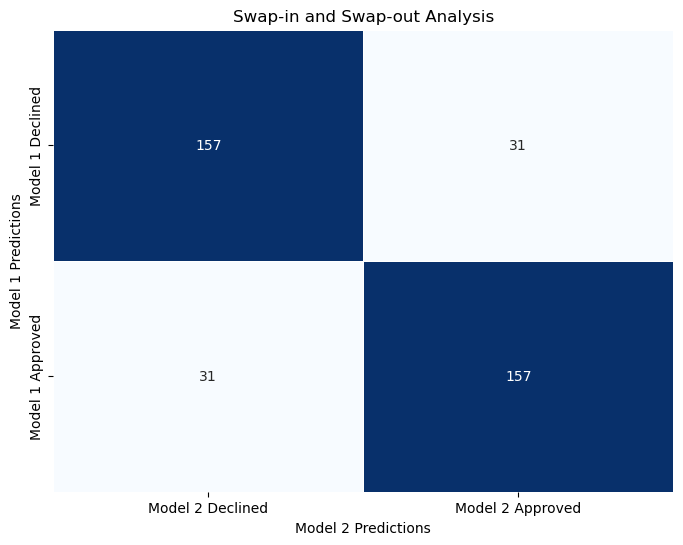

In [44]:
# Visualize the contingency table using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='g', cbar=False, linewidths=0.5)
plt.title('Swap-in and Swap-out Analysis')
plt.xlabel('Model 2 Predictions')
plt.ylabel('Model 1 Predictions')
plt.show()

## Explanation:

1. **Swap Set Analysis Function:** The swap_set_analysis function computes the swap-in and swap-out populations between probabilities_model1 and probabilities_model2 based on specified thresholds (threshold_model1 and threshold_model2).

2. **Contingency Table:** contingency_table is a pandas DataFrame that represents the 2x2 table. Each cell in the table shows the count of samples falling into each intersection based on the swap-in and swap-out criteria for Model 1 and Model 2.

3. **Heatmap Visualization:** The sns.heatmap function from Seaborn is used to visualize the contingency table. Annotations (annot=True) display the counts within each cell. Colors indicate the magnitude of counts, with higher counts represented by darker shades of blue.

4. **Interpretation:**

* Cells in the top-left (Model 1 Declined & Model 2 Declined) and bottom-right (Model 1 Approved & Model 2 Approved) corners represent the 'No Change' population.
* Cells in the top-right (Model 1 Declined & Model 2 Approved) and bottom-left (Model 1 Approved & Model 2 Declined) corners represent the 'Swap-in' and 'Swap-out' populations, respectively.

5. **Adjustments:** You can adjust the thresholds (threshold_model1 and threshold_model2) to explore how different cutoffs affect the swap sets and the contingency table.

This approach provides a clear visual representation of how the predictions from Model 1 and Model 2 intersect in terms of their swap-in, swap-out, and no-change populations based on your specified criteria. Adjustments can be made based on specific requirements or additional features you might want to include in the analysis.

In [66]:
swap_in

,Probability_model1,Probability_model2,y_true,Prediction_model1,Prediction_model2,Swap_in,Swap_out,No_change
374855,0.000000,0.13,1,0,1,True,False,False
331549,0.000000,0.11,1,0,1,True,False,False
346804,0.000000,0.10,1,0,1,True,False,False
42433,0.000000,0.10,1,0,1,True,False,False
154880,0.034029,0.19,1,0,1,True,False,False
309672,0.070000,0.17,1,0,1,True,False,False
188858,0.000000,0.11,1,0,1,True,False,False
181426,0.000000,0.16,1,0,1,True,False,False
357161,0.000000,0.10,1,0,1,True,False,False
326339,0.000000,0.10,1,0,1,True,False,False


In [67]:
swap_out

,Probability_model1,Probability_model2,y_true,Prediction_model1,Prediction_model2,Swap_in,Swap_out,No_change
206415,0.520000,0.01,1,1,0,False,True,False
173691,0.560000,0.03,1,1,0,False,True,False
418123,0.630000,0.00,7,1,0,False,True,False
347144,0.531639,0.00,1,1,0,False,True,False
419055,0.297143,0.00,7,1,0,False,True,False
...,...,...,...,...,...,...,...,...
400292,0.172370,0.00,3,1,0,False,True,False
379751,0.120000,0.01,1,1,0,False,True,False
341605,0.122167,0.01,1,1,0,False,True,False
78832,0.630000,0.01,1,1,0,False,True,False


In [68]:
no_change

,Probability_model1,Probability_model2,y_true,Prediction_model1,Prediction_model2,Swap_in,Swap_out,No_change
375979,0.000000,0.00,1,0,0,False,False,True
303172,0.000000,0.00,1,0,0,False,False,True
316388,0.000000,0.00,1,0,0,False,False,True
46926,0.000000,0.00,1,0,0,False,False,True
391889,0.000000,0.00,3,0,0,False,False,True
...,...,...,...,...,...,...,...,...
144892,0.078347,0.00,1,0,0,False,False,True
163470,0.000000,0.00,1,0,0,False,False,True
14812,0.000000,0.00,1,0,0,False,False,True
269089,0.000000,0.00,1,0,0,False,False,True


In [22]:
probabilities1

array([[0.03      , 0.72      , 0.        , ..., 0.08      , 0.        ,
        0.15      ],
       [0.        , 0.93343676, 0.        , ..., 0.        , 0.        ,
        0.00666231],
       [0.        , 0.92208019, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.92794109, 0.        , ..., 0.07205891, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02404442, 0.82702988, 0.00561657, ..., 0.        , 0.00651005,
        0.04456373]])

In [37]:
test=pd.DataFrame(probabilities1)
test

,0,1,2,3,4,5,6,7
0,0.030000,0.720000,0.000000,0.000000,0.020000,0.080000,0.000000,0.150000
1,0.000000,0.933437,0.000000,0.059901,0.000000,0.000000,0.000000,0.006662
2,0.000000,0.922080,0.000000,0.077920,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.943971,0.000000,0.011841,0.004843,0.039346,0.000000,0.000000
4,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
126324,0.000000,0.921653,0.078347,0.000000,0.000000,0.000000,0.000000,0.000000
126325,0.024205,0.917818,0.000000,0.039491,0.008159,0.000000,0.005135,0.005193
126326,0.000000,0.927941,0.000000,0.000000,0.000000,0.072059,0.000000,0.000000
126327,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
